## Import Libraries

In [2]:
#!pip install sklearn_pandas
import numpy as np
import csv
import sklearn
import sklearn_pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

## Read Data
Read in both the supervised training dataset and the unlabeled training data. 

Ensure both datasets contain the same features, no duplicates, and no missing values.

In [4]:
# Train (supervised) - drop the index column
df_train = pd.read_csv('./data/supervised_dataset.csv').iloc[:,1:]

# Test (unlabeled) - select columns present in train dataset
df_test = pd.read_csv('./data/remaining_behavior_ext.csv',usecols=[1,2,3,4,5,6,9,10,11,12])

# Remove duplicates and missing values
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)


print("Train dataset has %s entities and %d columns" %(df_train.shape[0], df_train.shape[1]))
print("Test dataset has %s entities and %d columns\n" %(df_test.shape[0], df_test.shape[1]))
print("Features [Train]:")
for i in df_train.columns:
    print("\t",i)
print("\nFeatures [Test]:")
for i in df_test.columns:
    print("\t",i)

Train dataset has 1674 entities and 11 columns
Test dataset has 33837 entities and 10 columns

Features [Train]:
	 _id
	 inter_api_access_duration(sec)
	 api_access_uniqueness
	 sequence_length(count)
	 vsession_duration(min)
	 ip_type
	 num_sessions
	 num_users
	 num_unique_apis
	 source
	 classification

Features [Test]:
	 _id
	 inter_api_access_duration(sec)
	 api_access_uniqueness
	 sequence_length(count)
	 vsession_duration(min)
	 ip_type
	 num_sessions
	 num_users
	 num_unique_apis
	 source


## Feature Visualization
The chart below is a heatmap of correlations between attributes, where blue shows a negative correlation and red/orange shows a positive correlation. 
#### Training Data

Some of the strongest correlations are:
- api_access_uniqueness (ratio of distinct APIs in user session to total API calls made in that session) is positively correlated with the classification (r=0.77)
- num_unique_apis (number of distinct APIs) and ip_type (type of IP the user came from) are negatively correlated with the classification (r=-0.45 and r=-0.43 respectively).
- num_users (number of users generating same type of API call sequences) and num_sessions (number of distinct sessions) are positively correlated with each other (r=0.93).


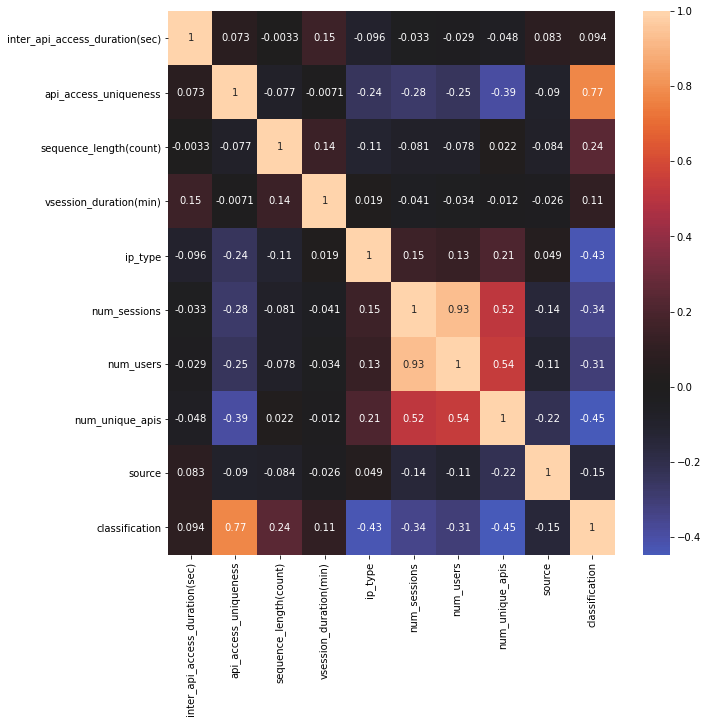

In [4]:
# Obtain a copy of the training dataset so as to not modify the original dataset
vis_train = copy.deepcopy(df_train)

# Transform the non-numeric features in vis_train (ip_type, source, classification)
# to numeric values to plot heatmap visualizing feature correlation

# Get the non-numeric (categorical) data
categorical_vis_train = vis_train.select_dtypes(include=["object"])
# Exclude IDs from label encoding
categorical_vis_train = categorical_vis_train.iloc[:,1:categorical_vis_train.shape[1]]

# Encode the categorical labels as integers:
    # ip_type ['default', 'datacenter'] -> [1, 0]
    # source ['E', 'F'] -> [0, 1]
    # classification ['normal', 'outlier'] -> [0, 1]
for col in categorical_vis_train:  
    enc = LabelEncoder()
    enc.fit(vis_train[col])
    vis_train[col] = enc.transform(vis_train[col])

# plot a correlation heatmap for our features.
# visualize the relationship between features and target
fig = plt.figure(figsize = (10,10))
sns.heatmap(vis_train.corr(), annot=True, center=0)
fig.savefig("./figures/heatmap_train.png")

#### Testing Data

Some of the strongest correlations are:
- sequence_length(count) (total number of API calls made in a session by a user on average) is positively correlated with the num_unique_apis (r=0.59)
- vsession_duration(min) (duration of user session within observation window) is positively correlated with inter_api_access_duration(sec) (time interval between two consecutive API accesses) (r=0.49)
- num_unique_apis is negatively correlated with api_access_uniqueness (r=-0.42)

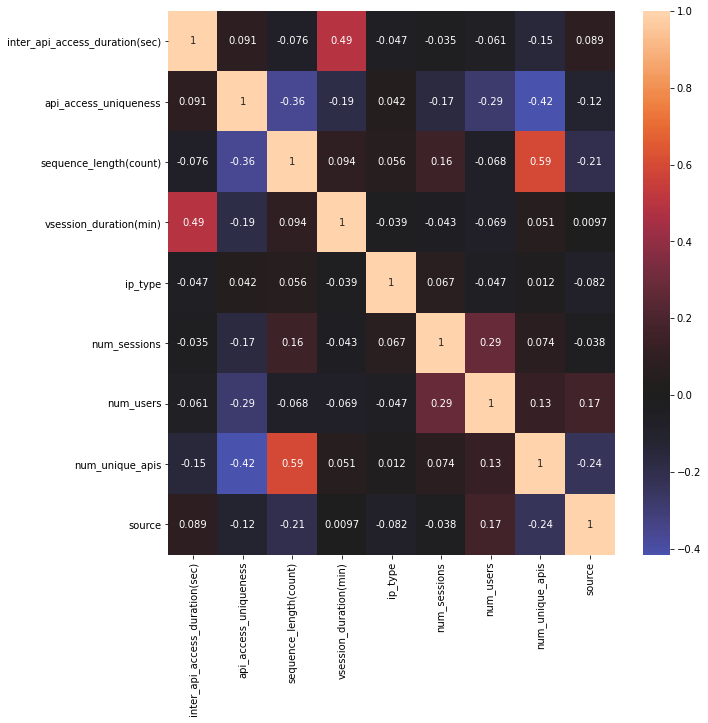

In [5]:
# Obtain a copy of the testing dataset so as to not modify the original dataset
vis_test = copy.deepcopy(df_test)

# Transform the non-numeric features in vis_test (ip_type, source)
# to numeric values to plot heatmap visualizing feature correlation

# Get the non-numeric (categorical) data
categorical_vis_test = vis_test.select_dtypes(include=["object"])
# Exclude IDs from label encoding
categorical_vis_test = categorical_vis_test.iloc[:,1:categorical_vis_test.shape[1]]

# Encode the categorical labels as integers:
    # ip_type ['default', 'datacenter'] -> [1, 0]
    # source ['E', 'F'] -> [0, 1]
for col in categorical_vis_test:  
    enc = LabelEncoder()
    enc.fit(vis_test[col])
    vis_test[col] = enc.transform(vis_test[col])

# plot a correlation heatmap for our features.
# visualize the relationship between features and target
fig = plt.figure(figsize = (10,10))
sns.heatmap(vis_test.corr(), annot=True, center=0)
fig.savefig("./figures/heatmap_test.png")

## Scale Training Data
Use StandardScaler to standardize features by removing the mean and scaling to unit variance.

Because the dataset has a mix of numeric and categorical data, the categorical values are replaced by 
integer labels through LabelEncoder (not scaled).

In [6]:
# Initiate Standard Scaler
sc_train = StandardScaler()

# Get the numeric (continuous) data 
num_train = df_train.select_dtypes(exclude=['object'])

# Update (numeric) columns with normalized values
df_train[num_train.columns] = sc_train.fit_transform(num_train)

# Get the non-numeric (categorical) data
categorical_train = df_train.select_dtypes(include=["object"])
# Exclude IDs from label encoding
categorical_train = categorical_train.iloc[:,1:categorical_train.shape[1]]

# Encode the categorical labels as integers:
    # ip_type ['default', 'datacenter'] -> [1, 0]
    # source ['E', 'F'] -> [0, 1]
    # classification ['normal', 'outlier'] -> [0, 1]
for col in categorical_train:  
    enc = LabelEncoder()
    enc.fit(df_train[col])
    df_train[col] = enc.transform(df_train[col])

## Scale Testing Data
Perform the same scaling procedure to the testing data (except for the classification feature which is not in the testing dataset)

In [7]:
# Initiate Standard Scaler
sc_test= StandardScaler()

# Get the numeric (continuous) data 
num_test= df_test.select_dtypes(exclude=['object'])

# Update (numeric) columns with normalized values
df_test[num_test.columns] = sc_test.fit_transform(num_test)

# Get the non-numeric (categorical) data
categorical_test= df_test.select_dtypes(include=["object"])
# Exclude IDs from label encoding
categorical_test= categorical_test.iloc[:,1:categorical_test.shape[1]]

# Encode the categorical labels as integers:
    # ip_type ['default', 'datacenter'] -> [1, 0]
    # source ['E', 'F'] -> [0, 1]
    # classification ['normal', 'outlier'] -> [0, 1]
for col in categorical_test:  
    enc = LabelEncoder()
    enc.fit(df_test[col])
    df_test[col] = enc.transform(df_test[col])

## Save Training and Testing Data

In [8]:
# Create X train/test and Y train objects, excluding IDs and classification
x_train = df_train.iloc[:,1:df_train.shape[1]-1]
y_train = df_train.iloc[:,df_train.shape[1]-1]
x_test = df_test.iloc[:,1:df_test.shape[1]]

# Save separate train/validation datasets to compute and plot the ROC of the models
x_train_roc, x_val_roc, y_train_roc, y_val_roc =  train_test_split(x_train, y_train, test_size=0.2, random_state=0)

# Datasets for model
pickle.dump(x_train,open("./data/x_train.pkl", "wb"))
pickle.dump(x_test,open("./data/x_test.pkl", "wb"))
pickle.dump(y_train,open("./data/y_train.pkl", "wb"))

# Datasets for ROC curve
pickle.dump(x_train_roc,open("./data/x_train_roc.pkl", "wb"))
pickle.dump(x_val_roc,open("./data/x_val_roc.pkl", "wb"))
pickle.dump(y_train_roc,open("./data/y_train_roc.pkl", "wb"))
pickle.dump(y_val_roc,open("./data/y_val_roc.pkl", "wb"))